In [2]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pandas as pd
import sqlite3

In [3]:
conn = sqlite3.connect("./data/database.sqlite")
cursor = conn.cursor()

# Get all table names
result = cursor.execute(
    "SELECT name FROM sqlite_master WHERE type='table';"
).fetchall()
print("Tables found:", result)

# Load each table into a dictionary of DataFrames
tables = {}
for table_tuple in result:
    table_name = table_tuple[0]
    tables[table_name] = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    print(
        f"✓ Loaded '{table_name}': {len(tables[table_name])} rows, {len(tables[table_name].columns)} columns"
    )

conn.close()

dfs: dict[str, pd.DataFrame] = tables

Tables found: [('sqlite_sequence',), ('Player_Attributes',), ('Player',), ('Match',), ('League',), ('Country',), ('Team',), ('Team_Attributes',)]
✓ Loaded 'sqlite_sequence': 7 rows, 2 columns
✓ Loaded 'Player_Attributes': 183978 rows, 42 columns
✓ Loaded 'Player': 11060 rows, 7 columns
✓ Loaded 'Match': 25979 rows, 115 columns
✓ Loaded 'League': 11 rows, 3 columns
✓ Loaded 'Country': 11 rows, 2 columns
✓ Loaded 'Team': 299 rows, 5 columns
✓ Loaded 'Team_Attributes': 1458 rows, 25 columns


In [ ]:
match_data = dfs["Match"]
data_sliced = match_data.iloc[:,11:77]
positions = pd.DataFrame(columns=['X','Y','player_id'])
for i in range(11):
    home = data_sliced[[f"home_player_X{i+1}", f"home_player_Y{i+1}", f"home_player_{i+1}"]]
    away = data_sliced[[f"away_player_X{i+1}", f"away_player_Y{i+1}", f"away_player_{i+1}"]]
    home.columns = ['X','Y','player_id']
    away.columns = ['X','Y','player_id']
    positions = pd.concat([positions, home, away], ignore_index=True)
positions.dropna(inplace=True)

C:\Users\tomtr\AppData\Local\Temp\ipykernel_43664\2922562886.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  positions = pd.concat([positions, home, away], ignore_index=True)


,X,Y,player_id
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


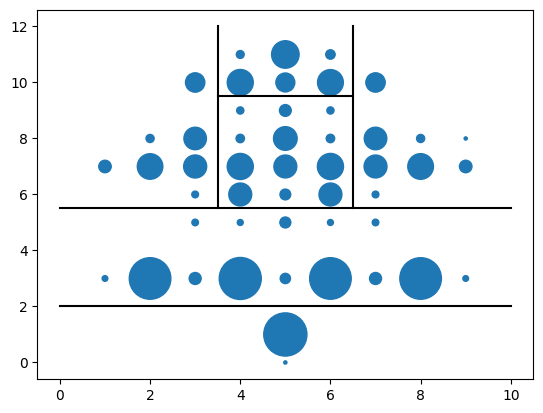

In [ ]:
dist = positions.groupby(['X','Y']).size()
distdf= dist.reset_index()
distdf.loc[distdf.Y==1.0,'X']=5.0 #moving goalkeeper position to (5,1) from ()
distdf.loc[distdf.Y==0.0,'X']=5.0 #moving goalkeeper position to (5,1) from ()
s = list(map(lambda x: 5 + x/50,distdf[0]))
distdf
plt.scatter(distdf['X'],distdf['Y'],s=s)
plt.plot([3.5,3.5],[5.5,12],c='black')
plt.plot([6.5,6.5],[5.5,12],c='black')
plt.plot([0,10],[5.5,5.5],c='black')
plt.plot([3.5,6.5],[9.5,9.5],c='black')
plt.plot([0,10],[2,2],c='black')

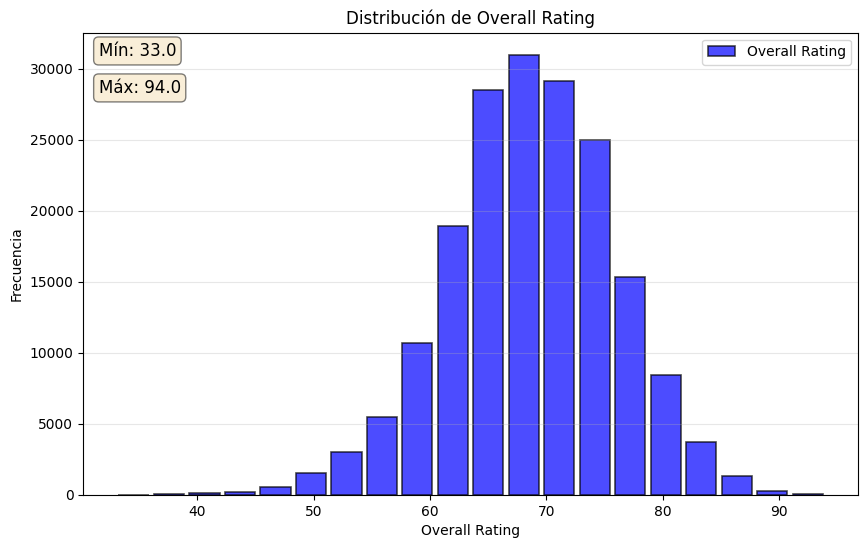

In [88]:
#  Grafico de distribucion de frecuencias : overall_rating. Separar un poco cada columna y ponerle border
attributes = dfs["Player_Attributes"]
plt.figure(figsize=(10, 6))
plt.hist(attributes['overall_rating'], bins=20, alpha=0.7, color='blue', 
         label='Overall Rating', edgecolor='black', linewidth=1.2, rwidth=0.85)
plt.xlabel('Overall Rating')
plt.ylabel('Frecuencia')
plt.title('Distribución de Overall Rating')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Agregar valores máximo y mínimo
min_val = attributes['overall_rating'].min()
max_val = attributes['overall_rating'].max()
plt.text(0.02, 0.98, f'Mín: {min_val}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.text(0.02, 0.90, f'Máx: {max_val}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()

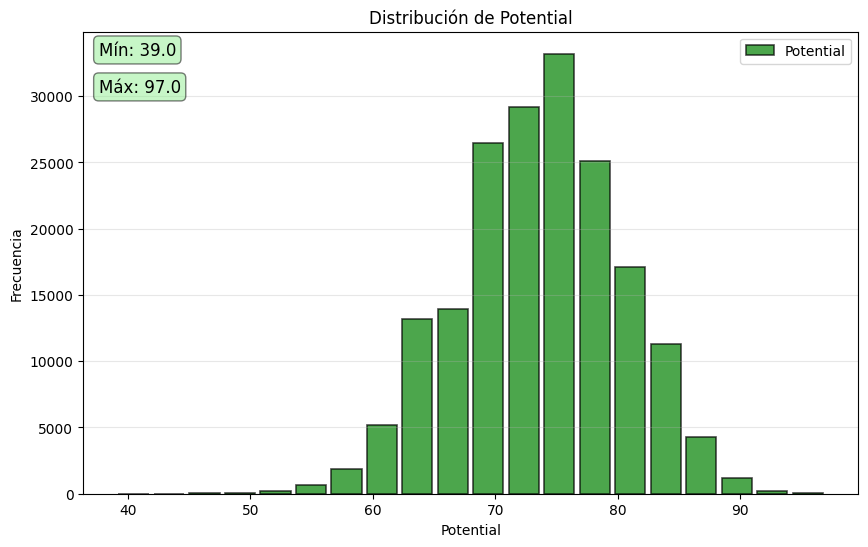

In [89]:
#  Grafico de distribucion de frecuencias : potential.
attributes = dfs["Player_Attributes"]
plt.figure(figsize=(10, 6))
plt.hist(attributes['potential'], bins=20, alpha=0.7, color='green', 
         label='Potential', edgecolor='black', linewidth=1.2, rwidth=0.85)
plt.xlabel('Potential')
plt.ylabel('Frecuencia')
plt.title('Distribución de Potential')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Agregar valores máximo y mínimo
min_val = attributes['potential'].min()
max_val = attributes['potential'].max()
plt.text(0.02, 0.98, f'Mín: {min_val}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
plt.text(0.02, 0.90, f'Máx: {max_val}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.show()

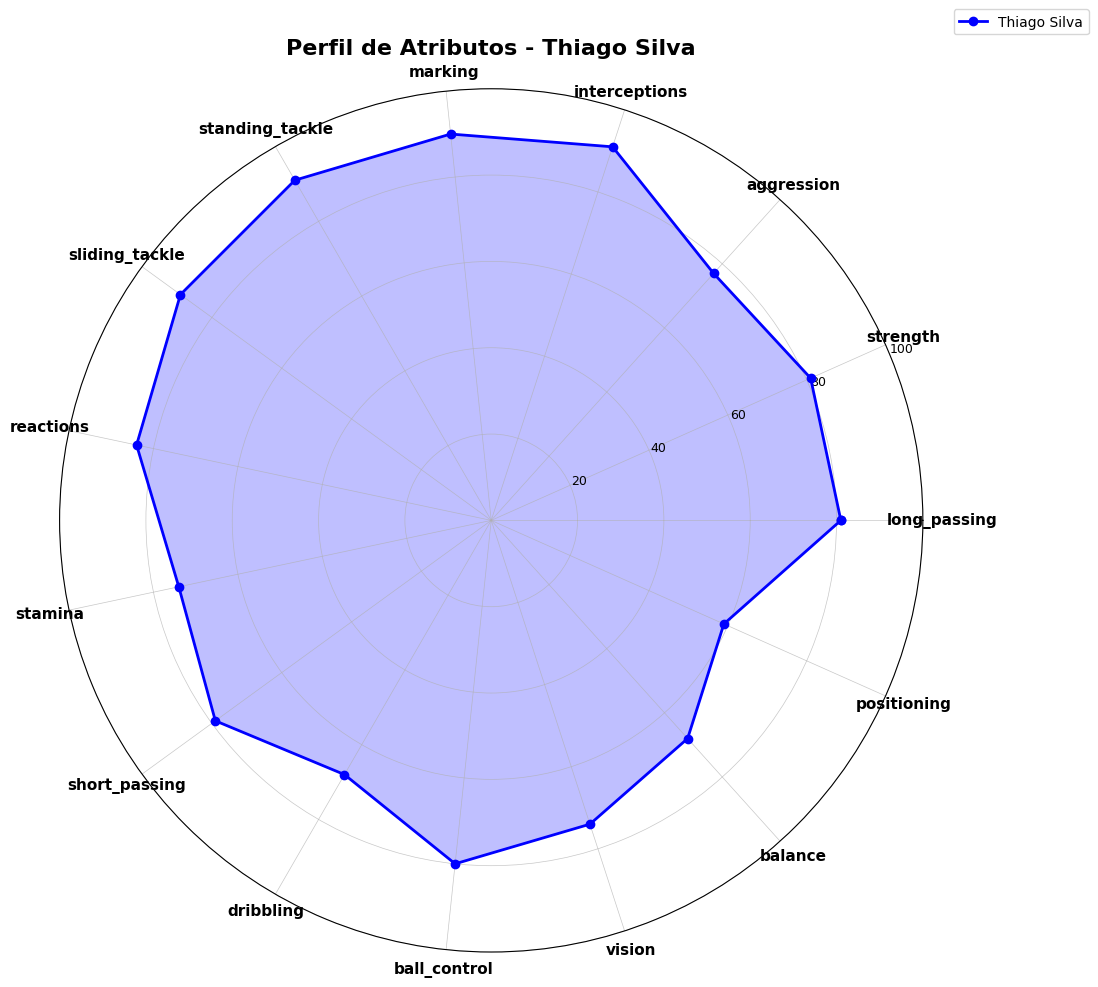

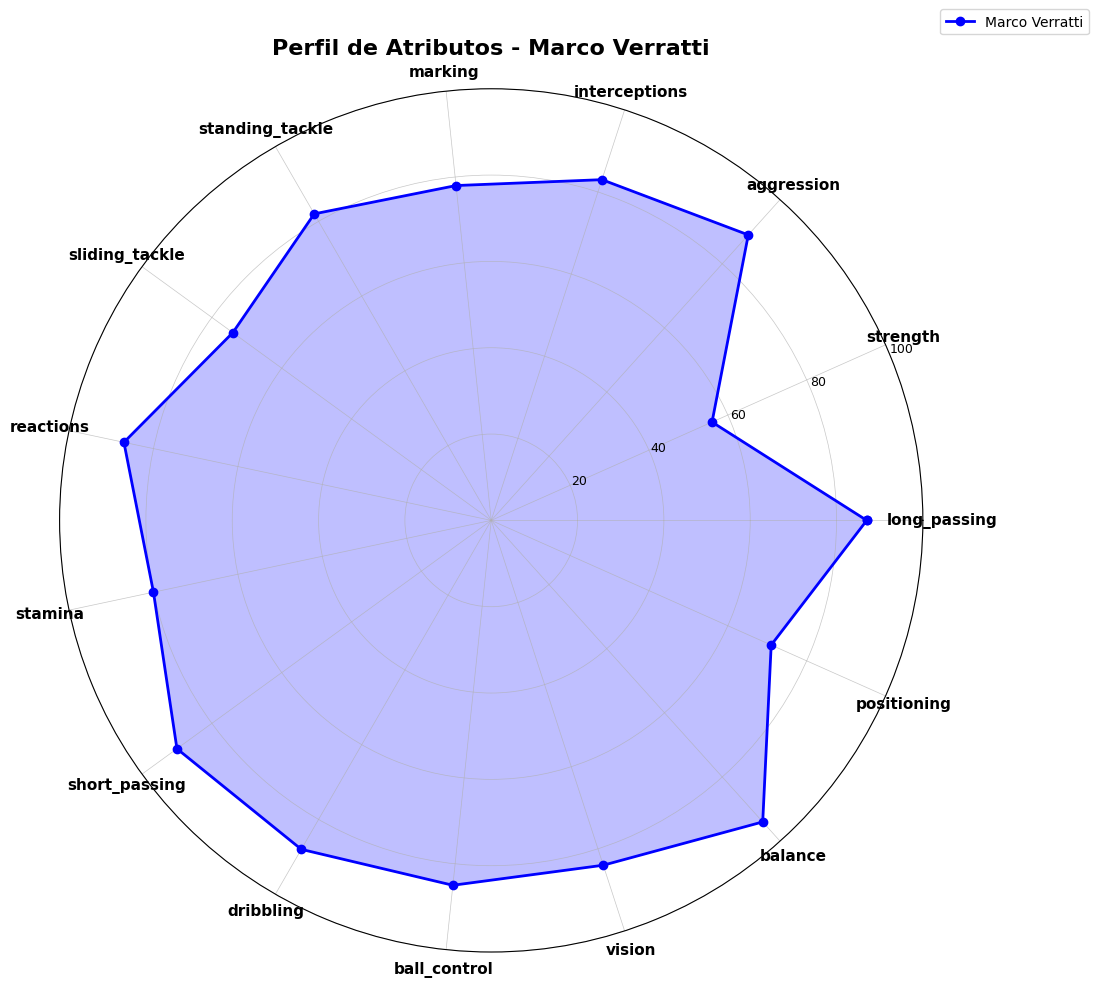

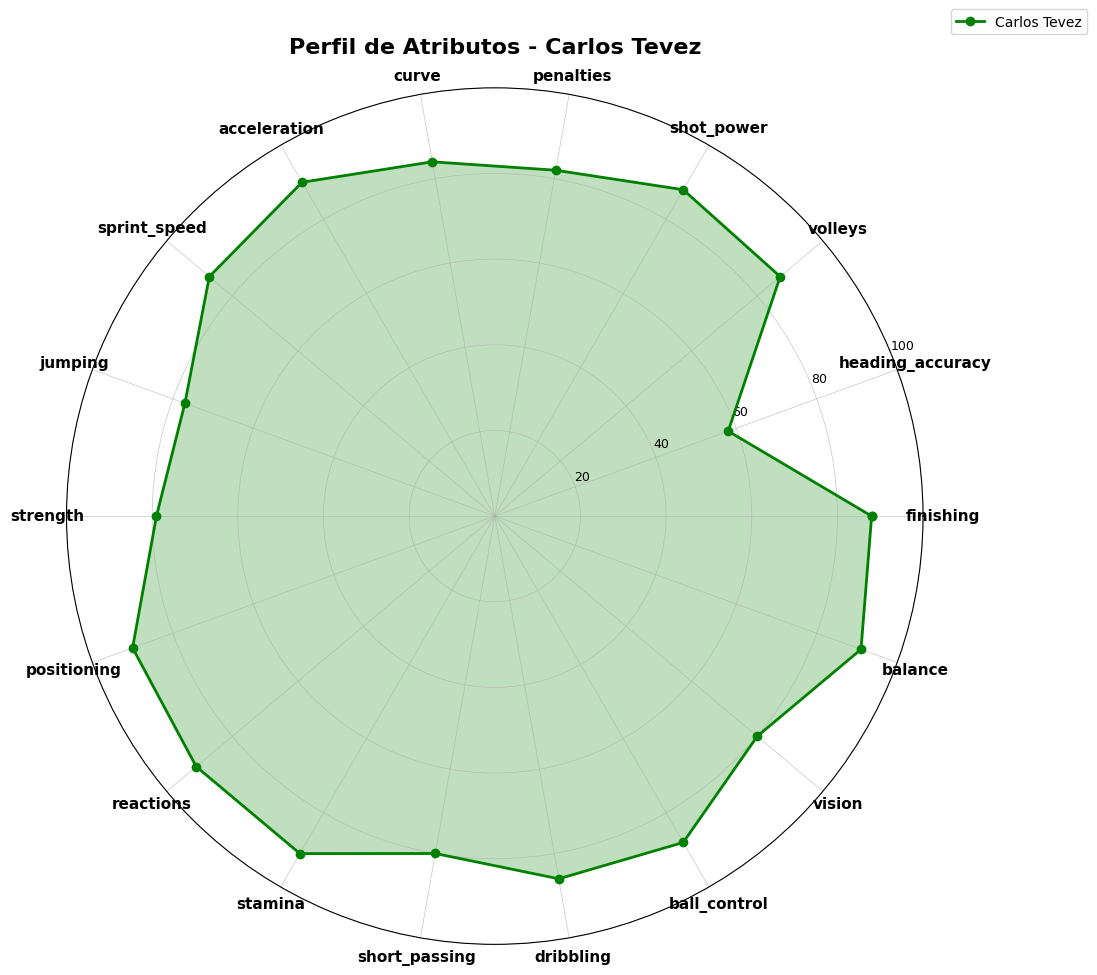

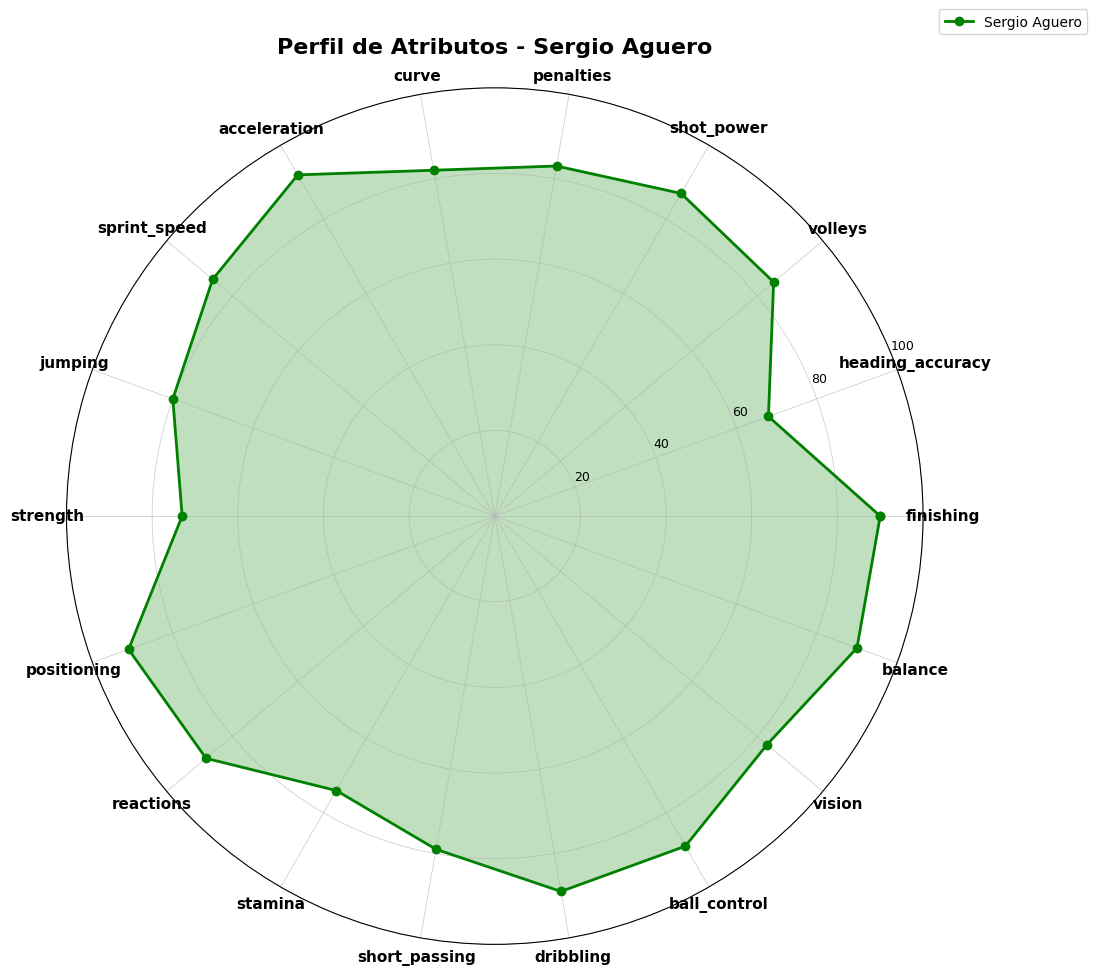

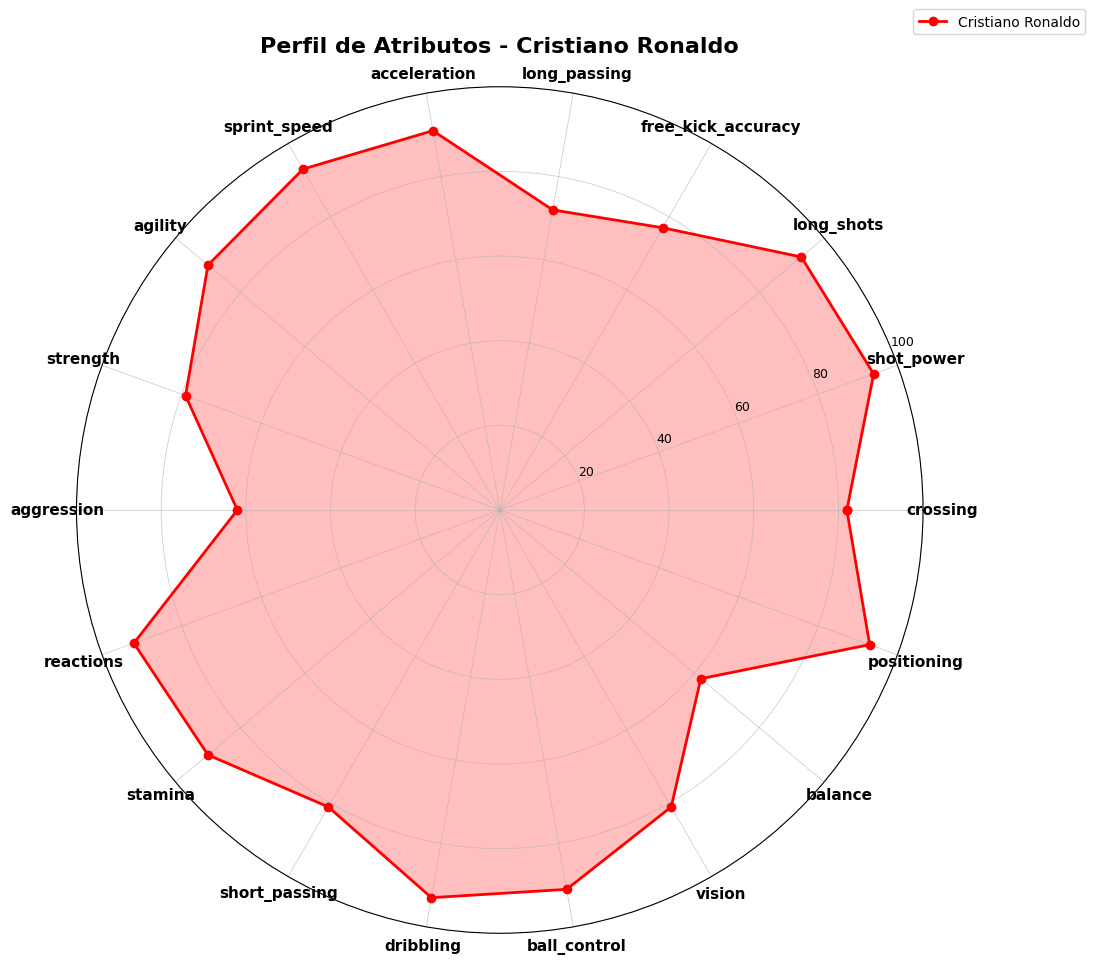

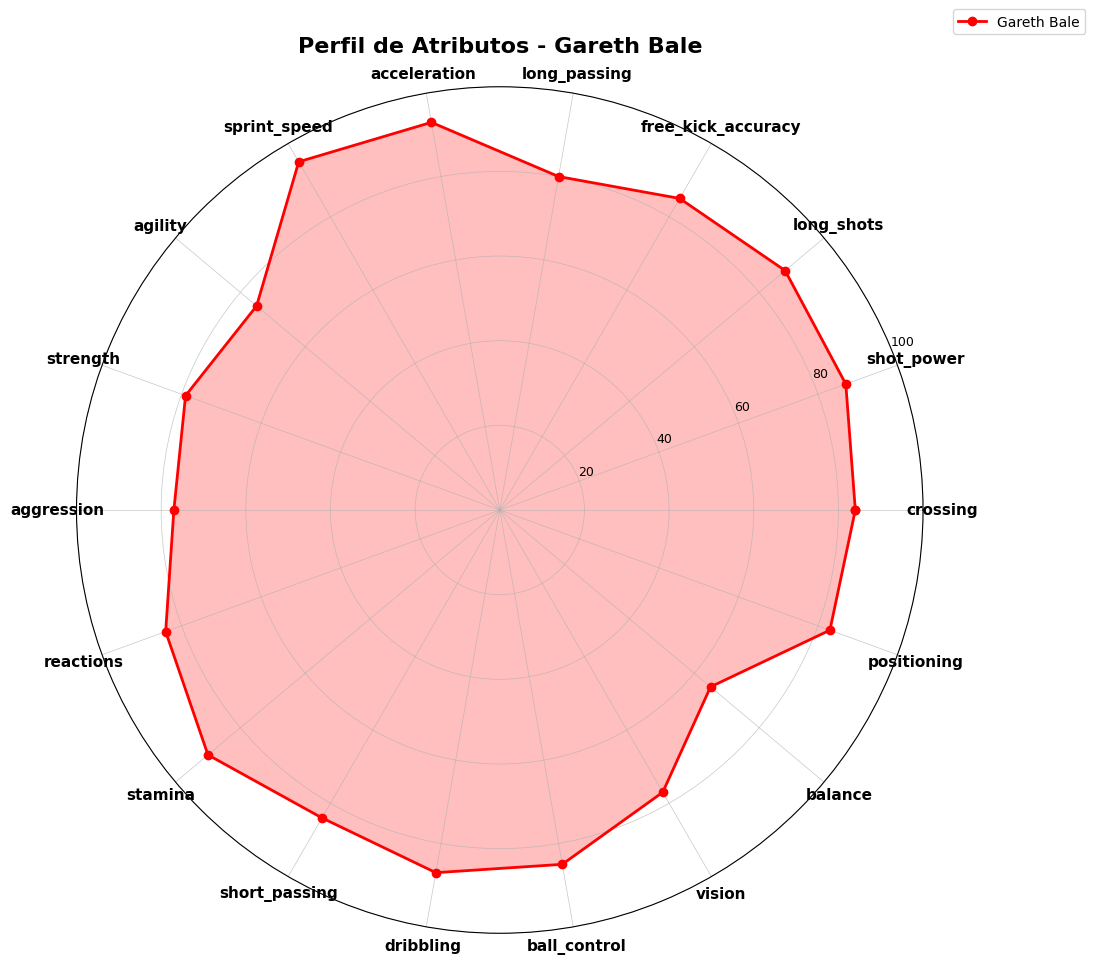

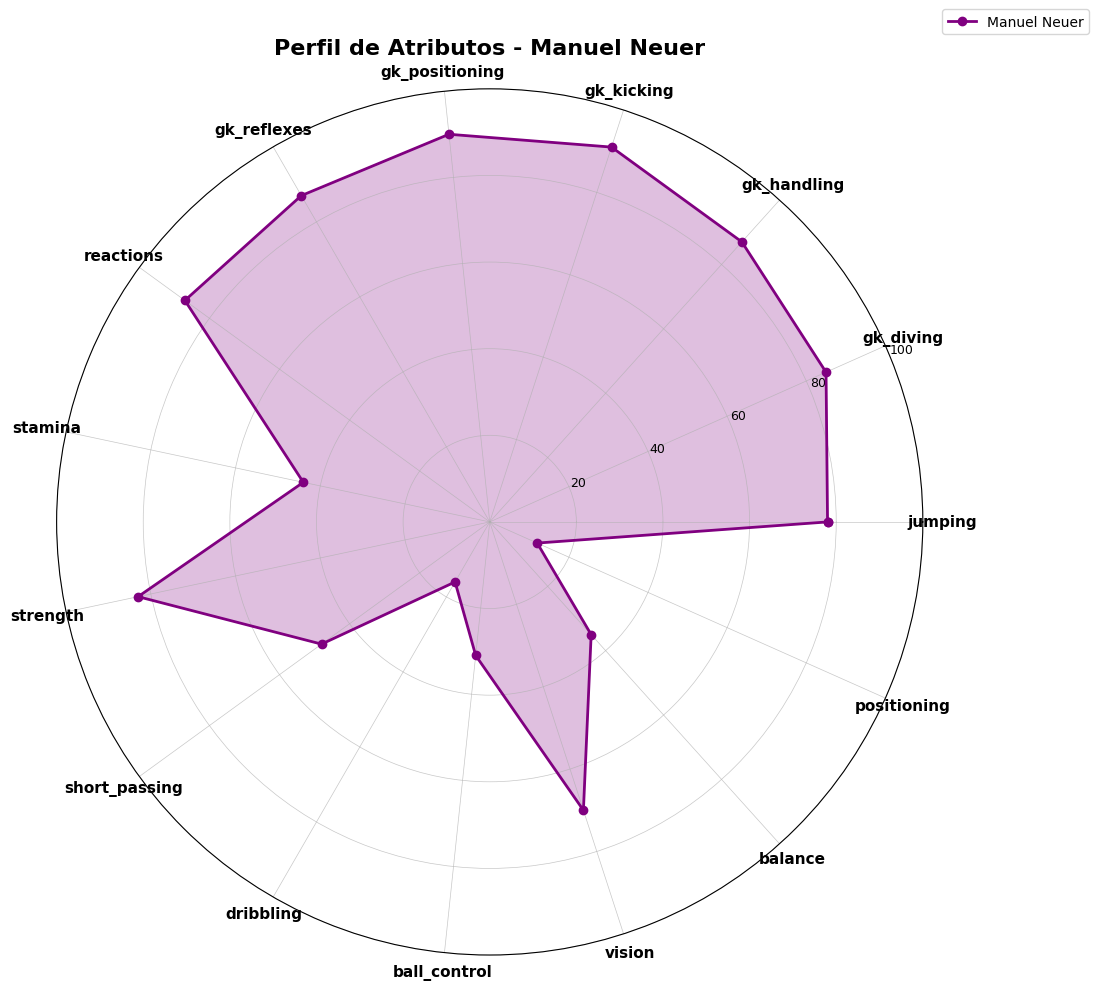

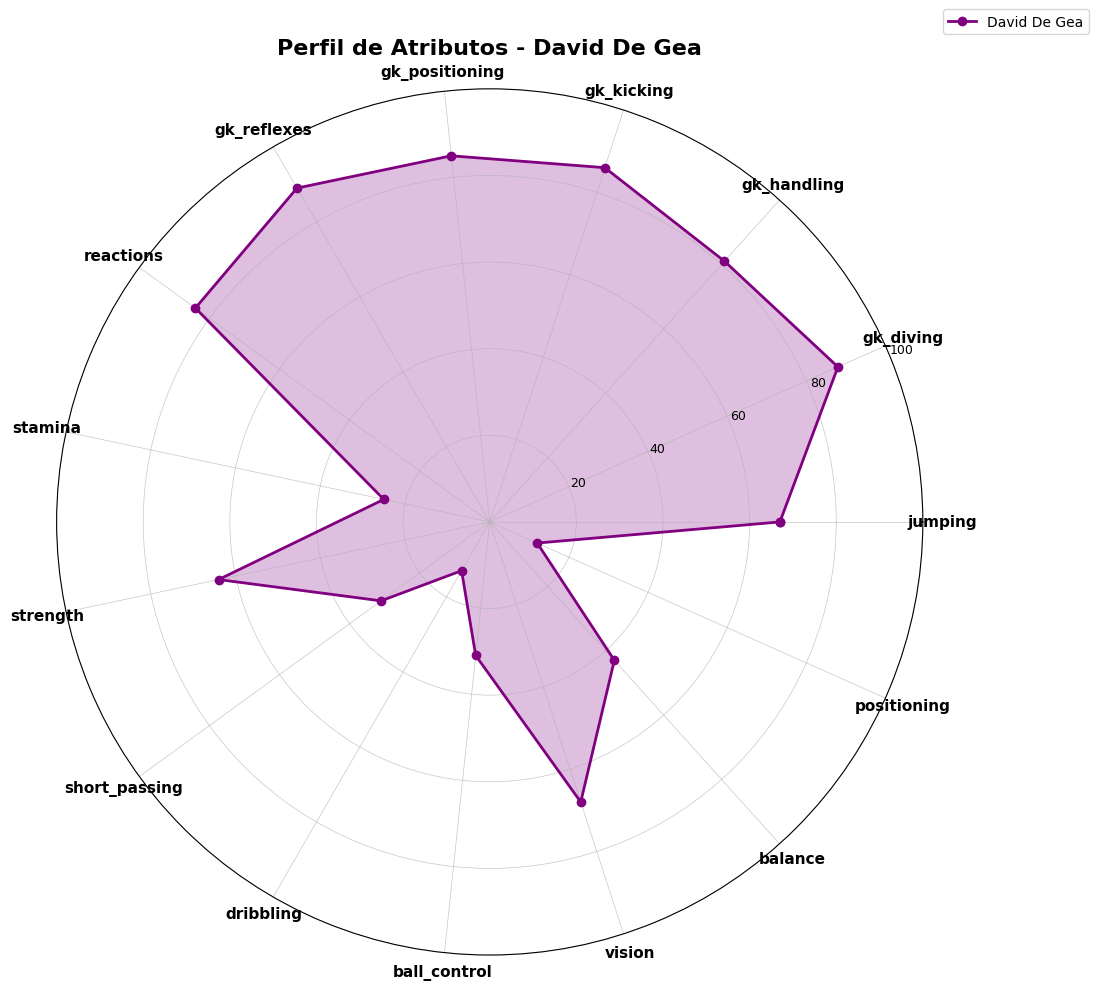

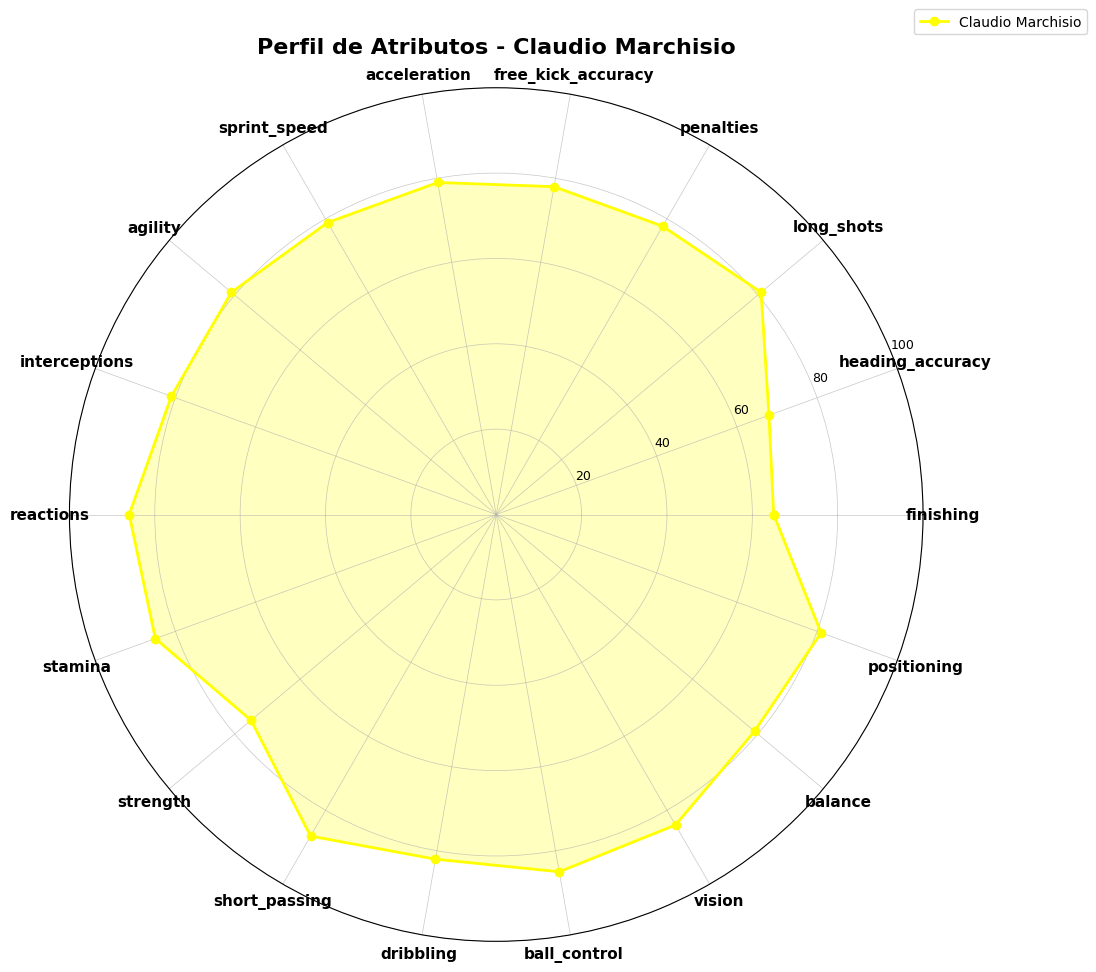

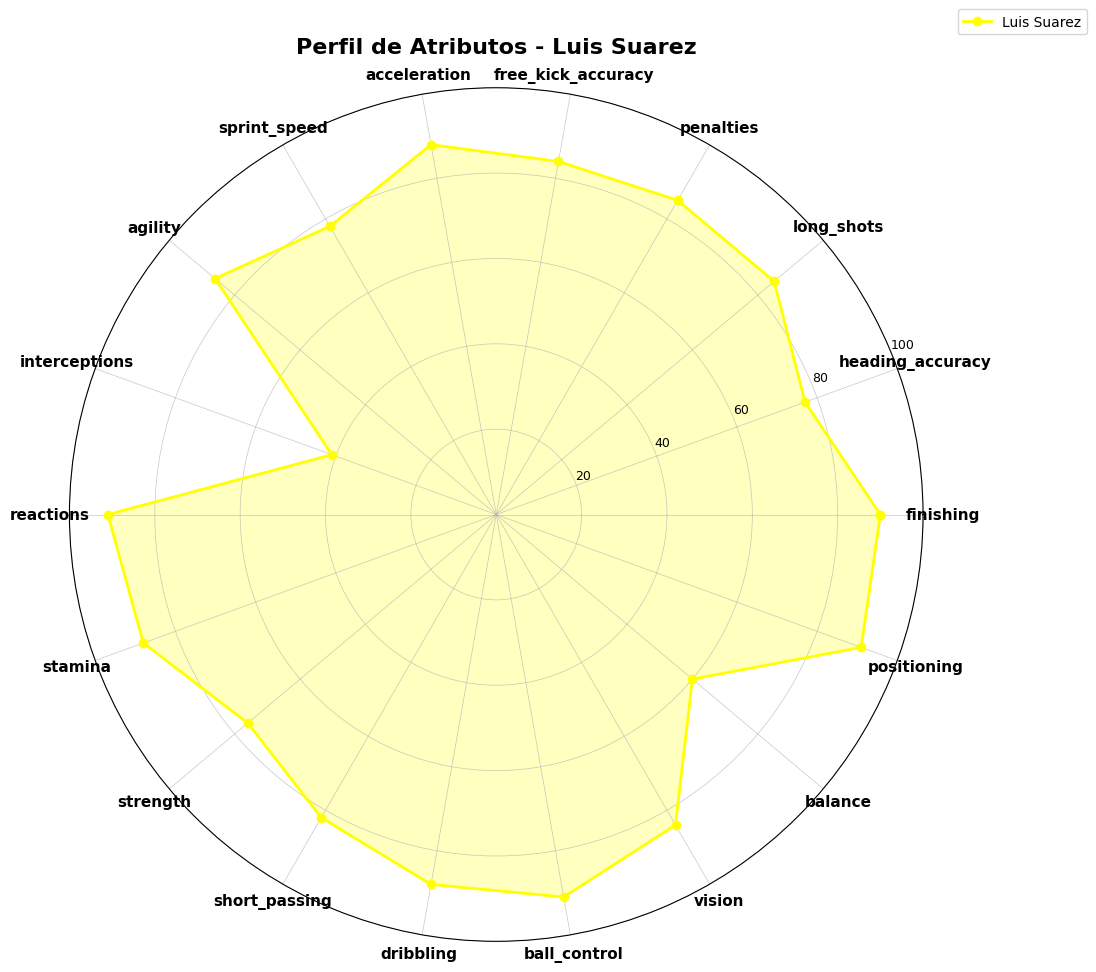

In [4]:
def player_radar_chart(player_name, color='blue', show_all_attrs=False, attrs_to_show=None, show_general_attrs=False):
    """
    Crea un radar chart de los atributos de un jugador
    
    Args:
        player_name: Nombre del jugador
        color: Color del gráfico
        show_all_attrs: Si True, muestra todos los atributos; si False, solo los principales
    """
    from math import pi
    
    general_attributes = [
        'reactions',
        'stamina',
        'strength',
        'short_passing',
        'dribbling',
        'ball_control',
        'vision',
        'reactions',
        'balance',
        'stamina',
        'positioning',
        ]
    
    # Obtener datos del jugador
    player = dfs["Player"][dfs["Player"]["player_name"] == player_name]
    
    if player.empty:
        print(f"Jugador '{player_name}' no encontrado")
        return
    
    player_attributes = dfs["Player_Attributes"]
    player_attributes = player_attributes[player_attributes["player_api_id"] == player["player_api_id"].values[0]]
    player_attributes = player_attributes.sort_values("date", ascending=False).iloc[0]
    
    if show_all_attrs:
        # Todos los atributos
        attrs = player_attributes.iloc[9:]  # Excluir IDs y fechas
        categories = attrs.index.tolist()
        values = attrs.values.tolist()
    else:
        key_attrs = player_attributes[attrs_to_show].to_dict()
        if show_general_attrs:
            key_attrs = {**key_attrs, **player_attributes[general_attributes].to_dict()}
        categories = list(key_attrs.keys())
        values = list(key_attrs.values())
    
    # Preparar ángulos
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values += values[:1]
    angles += angles[:1]
    
    # Crear gráfico
    fig, ax = plt.subplots(figsize=(11, 11), subplot_kw=dict(projection='polar'))
    
    ax.plot(angles, values, 'o-', linewidth=2, color=color, label=player_name)
    ax.fill(angles, values, alpha=0.25, color=color)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=11, weight='bold')
    ax.set_ylim(0, 100)
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_yticklabels(['20', '40', '60', '80', '100'], size=9)
    ax.grid(True, linewidth=0.5, alpha=0.7)
    
    plt.title(f'Perfil de Atributos - {player_name}', size=16, weight='bold', pad=25)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    
    plt.tight_layout()
    plt.show()

attributes_roles = {
    "portero": [
        'jumping',
        'gk_diving',
        'gk_handling',
        'gk_kicking',
        'gk_positioning',
        'gk_reflexes',
        
    ],
    "defensa": [
        'long_passing',
        'strength',
        'aggression',
        'interceptions',
        'marking',
        'standing_tackle',
        'sliding_tackle'
    ],
    "volante": [
        'finishing',
        'heading_accuracy',
        'long_shots',
        'penalties',
        'free_kick_accuracy',
        'acceleration',
        'sprint_speed',
        'agility',
        'interceptions'
    ],
    "delantero": [
        'finishing',
        'heading_accuracy',
        'volleys',
        'shot_power',
        'penalties',
        'curve',
        'acceleration',
        'sprint_speed',
        'jumping',
        'strength',
        'positioning'
    ],
    "extremo": [
        'crossing',
        'shot_power',
        'long_shots',
        'free_kick_accuracy',
        'long_passing',
        'acceleration',
        'sprint_speed',
        'agility',
        'strength',
        'aggression'
    ]
}

# Ejemplo de uso
player_radar_chart("Thiago Silva", color='blue', attrs_to_show=attributes_roles["defensa"], show_general_attrs=True)
player_radar_chart("Marco Verratti", color='blue', attrs_to_show=attributes_roles["defensa"], show_general_attrs=True)

player_radar_chart("Carlos Tevez", color='green', attrs_to_show=attributes_roles["delantero"], show_general_attrs=True)
player_radar_chart("Sergio Aguero", color='green', attrs_to_show=attributes_roles["delantero"], show_general_attrs=True)

player_radar_chart("Cristiano Ronaldo", color='red', attrs_to_show=attributes_roles["extremo"], show_general_attrs=True)
player_radar_chart("Gareth Bale", color='red', attrs_to_show=attributes_roles["extremo"], show_general_attrs=True)

player_radar_chart("Manuel Neuer", color='purple', attrs_to_show=attributes_roles["portero"], show_general_attrs=True)
player_radar_chart("David De Gea", color='purple', attrs_to_show=attributes_roles["portero"], show_general_attrs=True)

player_radar_chart("Claudio Marchisio", color='yellow', attrs_to_show=attributes_roles["volante"], show_general_attrs=True)
player_radar_chart("Luis Suarez", color='yellow', attrs_to_show=attributes_roles["volante"], show_general_attrs=True)